In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# load data

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True)

In [3]:
x, y = iter(train_loader).next()
b_x = Variable(x)
b_y = Variable(y)

In [4]:
b_x.shape

torch.Size([256, 1, 28, 28])

In [19]:
a = nn.Conv2d(1, 16, kernel_size=2, padding=1)(b_x)
a.shape

torch.Size([256, 16, 29, 29])

In [20]:
a = F.relu(a, inplace=True)
a.shape

torch.Size([256, 16, 29, 29])

In [21]:
a = nn.MaxPool2d(kernel_size=2)(a)
a.shape

torch.Size([256, 16, 14, 14])

# train

In [38]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.fc = nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output, x

In [39]:
model = CNN().cuda()
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [31]:
images, labels = iter(train_loader).next()
print(images.size())
outputs = model(Variable(images.cuda()))
outputs

torch.Size([256, 1, 28, 28])


(Variable containing:
  0.0458 -0.0256  0.0442  ...   0.0898  0.0292  0.0045
  0.0511  0.0277  0.0391  ...   0.0533 -0.0131  0.0170
  0.0185  0.0016  0.0178  ...   0.0785 -0.0344  0.0549
           ...             ⋱             ...          
  0.0447  0.0315  0.0263  ...   0.0744  0.0002  0.0540
  0.0442  0.0182  0.0626  ...   0.0391 -0.0145  0.0179
 -0.0056  0.0220 -0.0240  ...   0.0316 -0.0186  0.0129
 [torch.cuda.FloatTensor of size 256x10 (GPU 0)], Variable containing:
  0.0365  0.0000  0.0084  ...   0.0125  0.0026  0.0000
  0.0365  0.0000  0.0000  ...   0.0920  0.0344  0.0000
  0.0365  0.0000  0.0000  ...   0.0000  0.0000  0.0000
           ...             ⋱             ...          
  0.0365  0.0000  0.0000  ...   0.0081  0.0000  0.0000
  0.0365  0.0000  0.0000  ...   0.0000  0.0102  0.0000
  0.0365  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 [torch.cuda.FloatTensor of size 256x1568 (GPU 0)])

In [76]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

def train(train_loader):
    model.train()
    train_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.cuda(), y.cuda()
        b_x = Variable(x)
        b_y = Variable(y)
        
        optimizer.zero_grad()
        outputs = model(b_x)
        
        loss = loss_func(outputs, b_y)
        train_loss += loss.data[0]

        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(train_loader)
    
    return train_loss

def valid(test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()
        b_x = Variable(x, volatile=True)
        b_y = Variable(y, volatile=True)
        
        outputs = model(b_x)
        loss = loss_func(outputs, b_y)
        test_loss += loss.data[0]
        
        pred = outputs.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).cpu().sum()
        total += b_y.size(0)

    val_loss = test_loss / len(test_loader)
    val_acc = correct / total
    
    return val_loss, val_acc

In [50]:
epochs = 10
loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(epochs):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)

    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
          % (epoch, loss, val_loss, val_acc))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 0.0190 val_loss: 0.0354 val_acc: 0.9888
epoch 1, loss: 0.0158 val_loss: 0.0456 val_acc: 0.9856
epoch 2, loss: 0.0139 val_loss: 0.0275 val_acc: 0.9902
epoch 3, loss: 0.0114 val_loss: 0.0316 val_acc: 0.9897
epoch 4, loss: 0.0092 val_loss: 0.0276 val_acc: 0.9910
epoch 5, loss: 0.0083 val_loss: 0.0273 val_acc: 0.9910
epoch 6, loss: 0.0065 val_loss: 0.0297 val_acc: 0.9907
epoch 7, loss: 0.0058 val_loss: 0.0332 val_acc: 0.9891
epoch 8, loss: 0.0057 val_loss: 0.0298 val_acc: 0.9913
epoch 9, loss: 0.0044 val_loss: 0.0281 val_acc: 0.9909


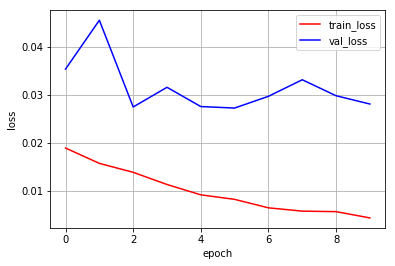

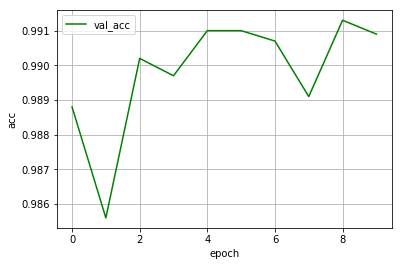

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(10), loss_list, 'r-', label='train_loss')
plt.plot(range(10), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(10), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()